In [5]:
from __future__ import print_function

import numpy as np
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras.layers.noise import GaussianNoise
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.utils import np_utils
from tensorflow.keras import regularizers

In [6]:
#set parameters

nb_filter = 64
filter_length_1 = 10
filter_length_2 = 7
hidden_dims = 10
batch_size = 64
nb_epoch = 30
nb_classes = 16

In [7]:
# #load the sequential MFCC data
# with open(os.path.join(proj_dir, 'seq_mfcc.pickle'), 'rb') as jar:
#   mfcc_data = pickle.load(jar)

mfcc_filename = "mfccs_dev_22050.csv"
dataset = pd.read_csv(mfcc_filename)
df = pd.DataFrame(dataset)
mfcc_data = df[["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_mean6","mfcc_mean7","mfcc_mean8","mfcc_mean9","mfcc_mean10","mfcc_mean11","mfcc_mean12","mfcc_mean13"]]
test_dim = mfcc_data.shape[0]

#set up targets (labels)
accent_data = pd.read_csv("cv-valid-dev-acc-mp3.csv")
targets_raw = np.array(accent_data['accent'])

label_encoder = LabelEncoder()
mfcc_targets = label_encoder.fit_transform(targets_raw)

X_train,X_test,y_train,y_test = train_test_split(
    mfcc_data,mfcc_targets,test_size=0.20,random_state=42
)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1],1)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

1080 train sequences
270 test sequences
X_train shape: (1080, 13, 1)
X_test shape: (270, 13, 1)
y_train shape: (1080,)
y_test shape: (270,)


In [13]:
#build model
model = Sequential()

#layer 1
#add a Convolution1D which will learn nb_filter mfcc groups:
model.add(Conv1D(filters=nb_filter,
                 kernel_size=filter_length_1,
                 input_shape=(X_train.shape[1], 1),
                 padding='valid', activation='relu'
                ))

#batch normalization to keep weights in [0,1] range:
model.add(BatchNormalization())

#layer2
model.add(Conv1D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same', activation='relu'
                ))

#standard maxpooling to halve the output of previous layer
model.add(MaxPooling1D(pool_size=2))

#layer3
model.add(BatchNormalization())
model.add(Conv1D(filters=nb_filter,
                 kernel_size=filter_length_2,
                 padding='same', activation='relu'
                ))
model.add(MaxPooling1D(pool_size=2))


#flatten the output of the convolutional layers
#so that we can add a vanilla dense layer
model.add(Flatten())

# Dropout reduces overfitting
model.add(Dropout(.25))

#project onto a single unit output layer
#and squash with a softmax into 0-1 probability space
model.add(Dense(nb_classes,activation='softmax',
               kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
               activity_regularizer=regularizers.l2(1e-5)))

#fit model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=["accuracy"])
model.summary()
history = model.fit(X_train,Y_train, batch_size=batch_size, epochs=nb_epoch, 
                    validation_data=(X_test, Y_test), verbose=1)

#print report of recall, precision, f1 score
y_pred = model.predict_classes(X_test)
print(classification_report(y_test,y_pred))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 4, 64)             704       
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 64)             256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 64)             28736     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 64)             256       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 64)             28736     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 64)            

/Users/yeojin_jung/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [109]:
#increased epoch from 10 to 30
#decreased nb_filters from 512 to 64
#increased dropout rate from 0.1 to 0.25 (accuracy converges to 0.85)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


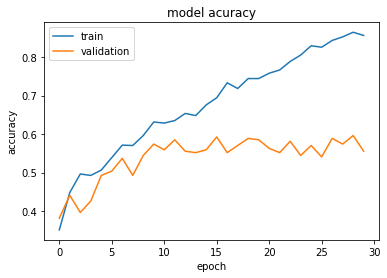

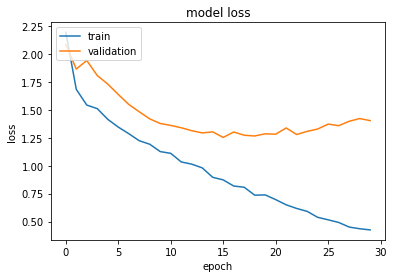

In [15]:
from keras.callbacks import History 
import matplotlib.pyplot as plt

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()